In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## As per the first step we will try to load the MNIST data

In [2]:
## load the mnist
print("loading MNIST ....")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
# mnist

loading MNIST ....


{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784)),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object),
 'frame': None,
 'categories': {'class': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',


In [3]:
# To take the input from the mnist_784 dataset 
X,y = mnist.data, mnist.target.astype(int)

In [4]:
# We need to normalize
X = X/255.0

In [5]:
# Performing one-hot encoding
def one_hot(y):
    target_one_hot = np.zeros((y.size, 10))
    target_one_hot[np.arange(y.size), y] = 1
    return target_one_hot.T


In [6]:
# 4. Split and Transpose
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X_train.T, X_test.T
y_train_oh = one_hot(y_train)
y_test_oh = one_hot(y_test)

In [7]:
print(f"Ready! Training on {X_train.shape[1]} images. Input features: {X_train.shape[0]}")

Ready! Training on 56000 images. Input features: 784


## The Core Classes (Activations, Loss, Optimizer)

In [8]:
class Activations:
    @staticmethod
    def relu(x): return np.maximum(0, x)
    
    @staticmethod
    def relu_derivative(x): return (x > 0).astype(float)
    
    @staticmethod
    def sigmoid(x):
        x = np.clip(x, -500, 500) # Stability clip
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def sigmoid_derivative(x):
        s = 1 / (1 + np.exp(-x))
        return s * (1 - s)

In [9]:
class Loss:
    @staticmethod
    def bce(y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    @staticmethod
    def bce_derivative(y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return (y_pred - y_true) / (y_pred * (1 - y_pred))

In [10]:
class AdamOptimizer:
    def __init__(self, lr=0.001, b1=0.9, b2=0.999, eps=1e-8):
        self.lr, self.b1, self.b2, self.eps = lr, b1, b2, eps
        self.m_w, self.v_w, self.m_b, self.v_b = {}, {}, {}, {}
        self.t = 0

    def update(self, layer_id, W, dW, b, db):
        if layer_id not in self.m_w:
            self.m_w[layer_id], self.v_w[layer_id] = np.zeros_like(W), np.zeros_like(W)
            self.m_b[layer_id], self.v_b[layer_id] = np.zeros_like(b), np.zeros_like(b)
        
        self.t += 1
        # Adam Math for Weights
        self.m_w[layer_id] = self.b1 * self.m_w[layer_id] + (1 - self.b1) * dW
        self.v_w[layer_id] = self.b2 * self.v_w[layer_id] + (1 - self.b2) * (dW**2)
        m_hat = self.m_w[layer_id] / (1 - self.b1**self.t)
        v_hat = self.v_w[layer_id] / (1 - self.b2**self.t)
        W -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
        
        # Adam Math for Bias
        self.m_b[layer_id] = self.b1 * self.m_b[layer_id] + (1 - self.b1) * db
        self.v_b[layer_id] = self.b2 * self.v_b[layer_id] + (1 - self.b2) * (db**2)
        mb_hat = self.m_b[layer_id] / (1 - self.b1**self.t)
        vb_hat = self.v_b[layer_id] / (1 - self.b2**self.t)
        b -= self.lr * mb_hat / (np.sqrt(vb_hat) + self.eps)
        
        return W, b

In [ ]:
class Layer:
    def __init__(self, in_size, out_size, act, d_act):
        # Xavier/He Initialization
        self.W = np.random.randn(out_size, in_size) * np.sqrt(2. / in_size)
        self.b = np.zeros((out_size, 1))
        self.act, self.d_act = act, d_act

    def forward(self, A_prev):
        self.A_prev = A_prev
        self.Z = np.dot(self.W, A_prev) + self.b
        return self.act(self.Z)

    def backward(self, dA):
        m = self.A_prev.shape[1]
        dZ = dA * self.d_act(self.Z)
        self.dW = np.dot(dZ, self.A_prev.T) / m
        self.db = np.sum(dZ, axis=1, keepdims=True) / m
        return np.dot(self.W.T, dZ)

class NeuralNetwork:
    def __init__(self, optimizer):
        self.layers = []
        self.optimizer = optimizer

    def add(self, in_s, out_s, act, d_act):
        self.layers.append(Layer(in_s, out_s, act, d_act))

    def train(self, X_train, y_train, epochs, batch_size):
        m = X_train.shape[1]
        for epoch in range(epochs):
            perm = np.random.permutation(m)
            X_s, y_s = X_train[:, perm], y_train[:, perm]
            loss_total = 0
            
            for i in range(0, m, batch_size):
                x_b, y_b = X_s[:, i:i+batch_size], y_s[:, i:i+batch_size]
                
                # Forward
                act_out = x_b
                for layer in self.layers: act_out = layer.forward(act_out)
                
                loss_total += Loss.bce(y_b, act_out)
                
                # Backward
                dA = Loss.bce_derivative(y_b, act_out)
                for layer in reversed(self.layers): dA = layer.backward(dA)
                
                # Update
                for l_idx, layer in enumerate(self.layers):
                    layer.W, layer.b = self.optimizer.update(l_idx, layer.W, layer.dW, layer.b, layer.db)
            
            print(f"Epoch {epoch} | Loss: {loss_total/(m/batch_size):.4f}")

## Layer and Network Framework

In [11]:
class Layer:
    def __init__(self, in_size, out_size, act, d_act):
        # Xavier/He Initialization
        self.W = np.random.randn(out_size, in_size) * np.sqrt(2. / in_size)
        self.b = np.zeros((out_size, 1))
        self.act, self.d_act = act, d_act

    def forward(self, A_prev):
        self.A_prev = A_prev
        self.Z = np.dot(self.W, A_prev) + self.b
        return self.act(self.Z)

    def backward(self, dA):
        m = self.A_prev.shape[1]
        dZ = dA * self.d_act(self.Z)
        self.dW = np.dot(dZ, self.A_prev.T) / m
        self.db = np.sum(dZ, axis=1, keepdims=True) / m
        return np.dot(self.W.T, dZ)

In [12]:
class NeuralNetwork:
    def __init__(self, optimizer):
        self.layers = []
        self.optimizer = optimizer

    def add(self, in_s, out_s, act, d_act):
        self.layers.append(Layer(in_s, out_s, act, d_act))

    def train(self, X_train, y_train, epochs, batch_size):
        m = X_train.shape[1]
        for epoch in range(epochs):
            perm = np.random.permutation(m)
            X_s, y_s = X_train[:, perm], y_train[:, perm]
            loss_total = 0
            
            for i in range(0, m, batch_size):
                x_b, y_b = X_s[:, i:i+batch_size], y_s[:, i:i+batch_size]
                
                # Forward
                act_out = x_b
                for layer in self.layers: act_out = layer.forward(act_out)
                
                loss_total += Loss.bce(y_b, act_out)
                
                # Backward
                dA = Loss.bce_derivative(y_b, act_out)
                for layer in reversed(self.layers): dA = layer.backward(dA)
                
                # Update
                for l_idx, layer in enumerate(self.layers):
                    layer.W, layer.b = self.optimizer.update(l_idx, layer.W, layer.dW, layer.b, layer.db)
            
            print(f"Epoch {epoch} | Loss: {loss_total/(m/batch_size):.4f}")

## Execute the Project

In [13]:
# 1. Initialize
nn = NeuralNetwork(AdamOptimizer(lr=0.002))
nn.add(784, 128, Activations.relu, Activations.relu_derivative)
nn.add(128, 10, Activations.sigmoid, Activations.sigmoid_derivative)

# 2. Train (Using 10,000 images for speed, 10 epochs)
nn.train(X_train[:, :10000], y_train_oh[:, :10000], epochs=10, batch_size=64)

Epoch 0 | Loss: 0.1308
Epoch 1 | Loss: 0.0585
Epoch 2 | Loss: 0.0427
Epoch 3 | Loss: 0.0339
Epoch 4 | Loss: 0.0276
Epoch 5 | Loss: 0.0229
Epoch 6 | Loss: 0.0188
Epoch 7 | Loss: 0.0159
Epoch 8 | Loss: 0.0130
Epoch 9 | Loss: 0.0107


## Test and Visualize

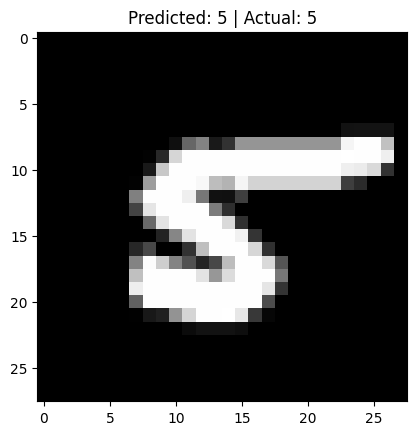

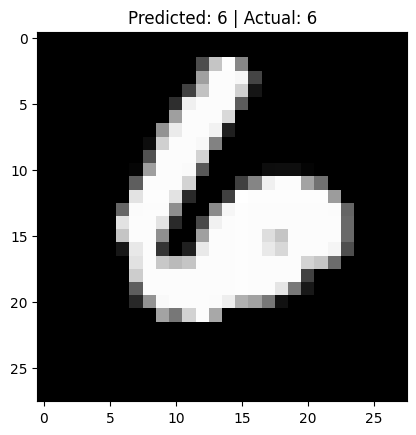

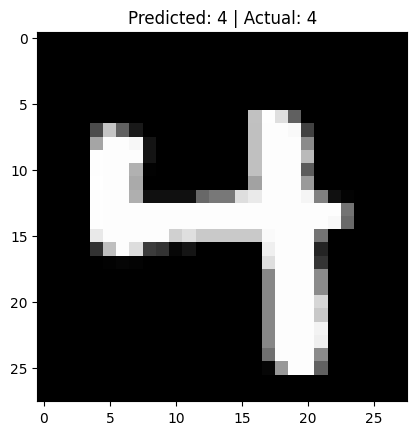

In [14]:
def check_results():
    idx = np.random.randint(0, X_test.shape[1])
    img = X_test[:, idx].reshape(784, 1)
    
    # Forward Pass
    out = img
    for layer in nn.layers: out = layer.forward(out)
    
    pred = np.argmax(out)
    actual = y_test[idx]
    
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {pred} | Actual: {actual}")
    plt.show()

for _ in range(3): check_results()

Our journey began with the Perceptron, the digital version of a single brain cell. We discovered its tragic flaw: it could only think in straight lines, meaning it failed the "XOR test" because it couldn't understand patterns that weren't perfectly separable. To fix this, we didn't just add more neurons; we added depth. We built a Multi-Layer Perceptron, creating "Hidden Layers" that act as a translator, warping complex, overlapping data into a shape the final layer can understand.

But a brain without a teacher is just random noise. So, we implemented Backpropagation, the "blame game" of mathematics. Whenever the model made a mistake, we used the Chain Rule of Calculus to trace that error backward from the output, through the activations, all the way to the very first weight, asking, "How much did YOU contribute to this mistake?"

As we scaled from the 2-feature XOR problem to the 784-feature MNIST problem, our simple math began to break. We faced the "Exploding Gradient," where the math became too big for the computer to hold. We fought back with Xavier Initialization to keep the weights balanced and Adam Optimization to give our model an "adaptive" steering wheel. We replaced the slow, steady crawl of standard Gradient Descent with Mini-Batches, feeding the model small, bite-sized pieces of data to keep the learning fast and dynamic.

In the end, we watched as the Loss—the measure of the model's confusion—collapsed from a chaotic 0.70 to a near-perfect 0.01. We finished not just with a program that can read digits, but with a modular, hand-crafted Framework that proves we understand the heartbeat of Artificial Intelligence: data, derivatives, and the relentless pursuit of lower error.